In [ ]:
import pandas as pd
from fbprophet import Prophet

# Load the data
df = pd.read_csv('complete_generation_forecasts.csv')

# Define the start and end of the gap
gap_start = pd.to_datetime('2022-06-29')
gap_end = pd.to_datetime('2022-10-16')

# Split the data into training and testing sets
train = df[(df['Time'] < gap_start) | (df['Time'] > gap_end)]
test = df[(df['Time'] >= gap_start) & (df['Time'] <= gap_end)]

# Prepare the data for Prophet
prophet_train = train.rename(columns={'Time': 'ds', 'Wind Offshore  [MW] Day Ahead': 'y'})

# Fit the Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True)
prophet_model.fit(prophet_train)

# Make predictions for the gap
prophet_future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
prophet_pred = prophet_model.predict(prophet_future)

# Get the predictions for the gap
prophet_pred = prophet_pred[prophet_pred['ds'].isin(test['Time'])]


Epoch 1/10
1810/1810 - 2s - loss: 0.0321 - 2s/epoch - 1ms/step
Epoch 2/10
1810/1810 - 1s - loss: 0.0265 - 1s/epoch - 689us/step
Epoch 3/10
1810/1810 - 1s - loss: 0.0265 - 1s/epoch - 688us/step
Epoch 4/10
1810/1810 - 1s - loss: 0.0265 - 1s/epoch - 677us/step
Epoch 5/10
1810/1810 - 1s - loss: 0.0265 - 1s/epoch - 679us/step
Epoch 6/10
1810/1810 - 1s - loss: 0.0264 - 1s/epoch - 680us/step
Epoch 7/10
1810/1810 - 1s - loss: 0.0264 - 1s/epoch - 689us/step
Epoch 8/10
1810/1810 - 1s - loss: 0.0264 - 1s/epoch - 684us/step
Epoch 9/10
1810/1810 - 1s - loss: 0.0264 - 1s/epoch - 686us/step
Epoch 10/10
1810/1810 - 1s - loss: 0.0265 - 1s/epoch - 693us/step
57/57 [==============================] - 0s 663us/step


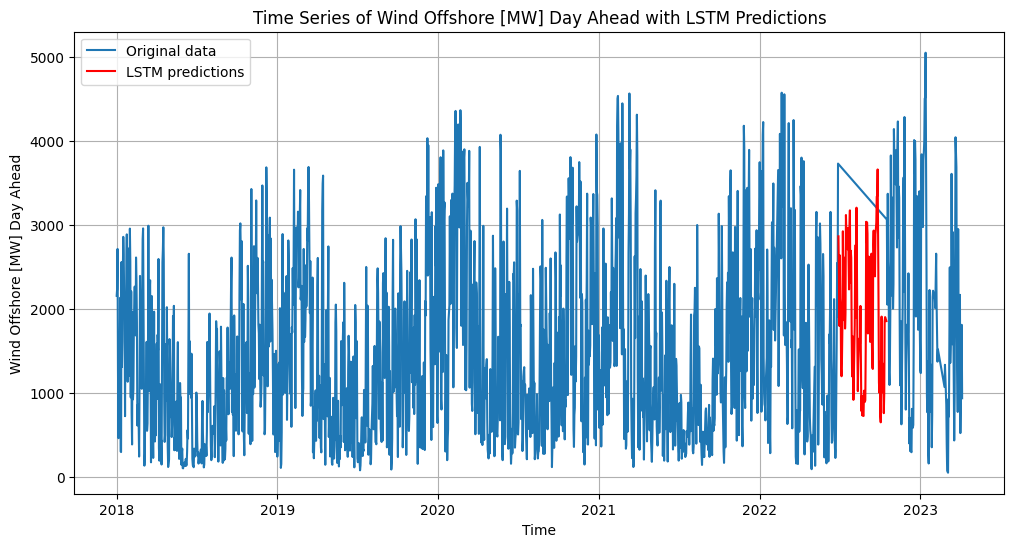

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('complete_generation_forecasts.csv', parse_dates=["Time"], dayfirst=True)

# Define the start and end of the gap
gap_start = pd.to_datetime('2022-06-29')
gap_end = pd.to_datetime('2022-10-16')

# Split the data into training and testing sets
train = df[(df['Time'] < gap_start) | (df['Time'] > gap_end)]
test = df[(df['Time'] >= gap_start) & (df['Time'] <= gap_end)]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Wind Offshore  [MW] Day Ahead']])

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the training dataset into the format expected by LSTMs
look_back = 1
trainX, trainY = create_dataset(train_scaled, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# Create and fit the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, look_back)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

# Make predictions for the training set
trainPredict = lstm_model.predict(trainX)

# Invert the predictions
trainPredict = scaler.inverse_transform(trainPredict)

# Shift the train predictions for plotting
trainPredictPlot = np.empty_like(df[['Wind Offshore  [MW] Day Ahead']])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Create a DataFrame for the LSTM predictions
lstm_pred = pd.DataFrame({
    'Time': df['Time'],
    'LSTM_Predictions': trainPredictPlot[:, 0]
})

# Get the LSTM predictions for the test set
lstm_pred_test = lstm_pred[(lstm_pred['Time'] >= gap_start) & (lstm_pred['Time'] <= gap_end)]

# Visualize the time series of Wind Offshore [MW] Day Ahead
plt.figure(figsize=(12, 6))
plt.plot(df["Time"], df["Wind Offshore  [MW] Day Ahead"], label='Original data')
plt.plot(lstm_pred_test['Time'], lstm_pred_test['LSTM_Predictions'], color='red', label='LSTM predictions')
plt.xlabel("Time")
plt.ylabel("Wind Offshore [MW] Day Ahead")
plt.title("Time Series of Wind Offshore [MW] Day Ahead with LSTM Predictions")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('complete_generation_forecasts.csv', parse_dates=["Time"], dayfirst=True)

# Define the start and end of the gap
gap_start = pd.to_datetime('2022-06-29')
gap_end = pd.to_datetime('2022-10-16')

# Split the data into training and testing sets
train = df[(df['Time'] < gap_start) | (df['Time'] > gap_end)]
test = df[(df['Time'] >= gap_start) & (df['Time'] <= gap_end)]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Wind Offshore  [MW] Day Ahead']])

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the training dataset into the format expected by LSTMs
look_back = 1
trainX, trainY = create_dataset(train_scaled, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# Create and fit the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, look_back)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

# Make predictions for the training set
trainPredict = lstm_model.predict(trainX)

# Invert the predictions
trainPredict = scaler.inverse_transform(trainPredict)

# Shift the train predictions for plotting
trainPredictPlot = np.empty_like(df[['Wind Offshore  [MW] Day Ahead']])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Create a DataFrame for the LSTM predictions
lstm_pred = pd.DataFrame({
    'Time': df['Time'],
    'LSTM_Predictions': trainPredictPlot[:, 0]
})

# Get the LSTM predictions for the test set
lstm_pred_test = lstm_pred[(lstm_pred['Time'] >= gap_start) & (lstm_pred['Time'] <= gap_end)]

# Replace the original values in the gap with the LSTM predictions
df.loc[(df['Time'] >= gap_start) & (df['Time'] <= gap_end), 'Wind Offshore  [MW] Day Ahead'] = lstm_pred_test['LSTM_Predictions'].values

# Save the modified DataFrame to a new CSV file
df.to_csv('complete_generation_forecasts_with_lstm_predictions.csv', index=False)


Epoch 1/10
1810/1810 - 2s - loss: 0.0320 - 2s/epoch - 1ms/step
Epoch 2/10
1810/1810 - 1s - loss: 0.0266 - 1s/epoch - 684us/step
Epoch 3/10
1810/1810 - 1s - loss: 0.0264 - 1s/epoch - 676us/step
Epoch 4/10
1810/1810 - 1s - loss: 0.0264 - 1s/epoch - 693us/step
Epoch 5/10
1810/1810 - 1s - loss: 0.0263 - 1s/epoch - 685us/step
Epoch 6/10
1810/1810 - 1s - loss: 0.0264 - 1s/epoch - 686us/step
Epoch 7/10
1810/1810 - 1s - loss: 0.0263 - 1s/epoch - 704us/step
Epoch 8/10
1810/1810 - 1s - loss: 0.0264 - 1s/epoch - 691us/step
Epoch 9/10
1810/1810 - 1s - loss: 0.0265 - 1s/epoch - 704us/step
Epoch 10/10
1810/1810 - 1s - loss: 0.0265 - 1s/epoch - 691us/step
57/57 [==============================] - 0s 641us/step
